In [1]:
#The data, once extracted, is contained within 22 files with .sgm file extension, a legacy markup format.
#To proceed, we need to convert to .xml.  I will use the unix command osx from the library OpenSP.
#OpenSP is not a standard library, but can be installed via the Homebrew Package Manager.
#Homebrew is built for the macOS operating system.
#For other environments, a different solution will need to be found to obtain OpenSP.

#The installation of Homebrew was done with the following command at terminal:
#ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" < /dev/null 2> /dev/null

#With Homebrew installed, I installed the OpenSP package with the following command at terminal:
#brew install open-sp

import requests
import tempfile
from os import path
import tarfile
import subprocess
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import collections
from scipy.stats import t
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, hamming_loss

In [2]:
#Data acquisition

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/reuters21578-mld/reuters21578.tar.gz'
resp = requests.get(url)
data_dict = {'title':[], 'text':[], 'topic_set':[]}
corpus_topic_set = set()

with tempfile.TemporaryDirectory() as tmp_dir:
    targz_path = path.join(tmp_dir, 'reuters21578.tar.gz')
    with open(targz_path, 'wb') as targz_file:
        targz_file.write(resp.content)
    with tarfile.open(targz_path, 'r:gz') as targz_file:
        targz_file.extractall(path=tmp_dir)
    for num in range(22):
        sgm_path = path.join(tmp_dir, 'reut2-0' + str(num).zfill(2) + '.sgm')
        with open(sgm_path, 'r', encoding='cp1252') as sgm_file:
            xml_text = subprocess.run(['osx', '--directory=' + tmp_dir], stdin=sgm_file, \
                stdout=subprocess.PIPE, encoding='cp1252').stdout
        soup = BeautifulSoup(xml_text, 'xml')
        for article in soup.find_all('REUTERS'):
            if (article.TOPICS is not None) & (article.TOPICS.D is not None) & \
                (article.TITLE is not None) & (article.BODY is not None):
                topic_set = {re.sub('-', '', topic.string) for topic in article.TOPICS.find_all('D')}
                corpus_topic_set.update(topic_set)
                data_dict['topic_set'].append(topic_set)
                data_dict['title'].append(article.TITLE.string)
                data_dict['text'].append(article.BODY.string)
for topic in corpus_topic_set:
    data_dict[topic] = [int(topic in topic_set) for topic_set in data_dict['topic_set']]
del data_dict['topic_set']
data_df = pd.DataFrame(data_dict)
binary_df = data_df.drop(columns=['title', 'text'])
drop_columns = binary_df.columns[binary_df.sum(axis='index') <= 10].values
data_df.drop(columns=drop_columns, inplace=True)
data_df['topic_count'] = data_df.sum(axis='columns', numeric_only=True)
data_df = data_df[data_df.topic_count > 0]

In [3]:
data_df.head()

,title,text,interest,reserves,soymeal,wpi,trade,barley,dlr,livestock,...,oat,income,palmoil,cpi,copper,tea,earn,carcass,zinc,topic_count
0,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,6
2,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show crop regist...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
3,CHAMPION PRODUCTS lt;CH APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,COMPUTER TERMINAL SYSTEMS lt;CPML COMPLETES SALE,Computer Terminal Systems Inc said it has comp...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10350 entries, 0 to 10376
Data columns (total 69 columns):
title             10350 non-null object
text              10350 non-null object
interest          10350 non-null int64
reserves          10350 non-null int64
soymeal           10350 non-null int64
wpi               10350 non-null int64
trade             10350 non-null int64
barley            10350 non-null int64
dlr               10350 non-null int64
livestock         10350 non-null int64
lei               10350 non-null int64
yen               10350 non-null int64
sorghum           10350 non-null int64
silver            10350 non-null int64
heat              10350 non-null int64
hog               10350 non-null int64
ship              10350 non-null int64
cotton            10350 non-null int64
tin               10350 non-null int64
strategicmetal    10350 non-null int64
stg               10350 non-null int64
housing           10350 non-null int64
corn              10350 non-nul

In [5]:
#Exploratory Data Analysis using CountVectorizer without tuned parameters

eda_text_vectorizer = CountVectorizer(strip_accents='unicode', stop_words='english')
eda_text_matrix = eda_text_vectorizer.fit_transform(data_df.text)
eda_topic_matrix = data_df.drop(columns=['title', 'text', 'topic_count']).values

Proportion of nonzero entries: 0.01895183721270678


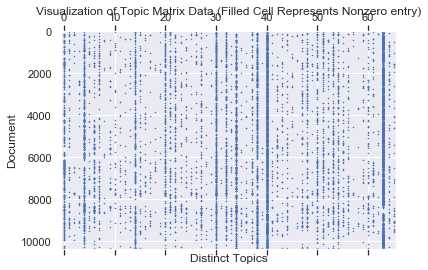

In [6]:
plt.spy(eda_topic_matrix, markersize=0.5, aspect='auto')
plt.title('Visualization of Topic Matrix Data (Filled Cell Represents Nonzero entry)')
plt.xlabel('Distinct Topics')
plt.ylabel('Document')
print('Proportion of nonzero entries: ' + str(np.count_nonzero(eda_topic_matrix)/len(eda_topic_matrix.flatten())))

Proportion of nonzero entries: 0.002043415700242474


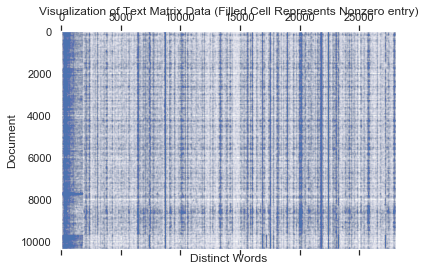

In [7]:
plt.spy(eda_text_matrix, markersize=0.01, aspect='auto')
plt.title('Visualization of Text Matrix Data (Filled Cell Represents Nonzero entry)')
plt.xlabel('Distinct Words')
plt.ylabel('Document')
print('Proportion of nonzero entries: ' + str(eda_text_matrix.getnnz()/len(eda_text_matrix.toarray().flatten())))

Text(0, 0.5, 'Log count')

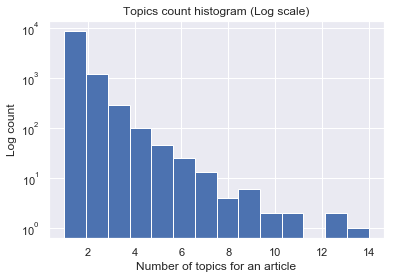

In [8]:
plt.hist(data_df.topic_count, log=True, bins=14)
plt.title('Topics count histogram (Log scale)')
plt.xlabel('Number of topics for an article')
plt.ylabel('Log count')

/Users/anayalatr/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Minimum topic occurence: 11.0
Median topic occurence: 57.5
75th percentile topic occurence: 131.25
95th percentile topic occurence: 572.0
99th percentile topic occurence: 2758.0999999999913
99.9th percentile topic occurence: 3674.2100000000037
Maximum topic occurence: 3776.0


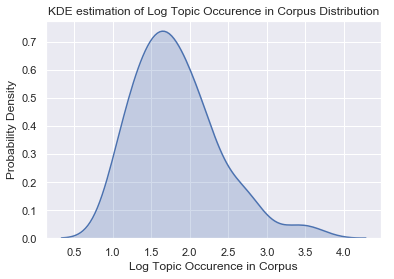

In [9]:
eda_topic_occurence = data_df.drop(columns=['title', 'text', 'topic_count']).sum(axis='index').values
eda_topic_percentiles = np.percentile(eda_topic_occurence, [0, 50, 75, 95, 99, 99.9, 100])
sns.kdeplot(np.log10(eda_topic_occurence), shade=True)
plt.title('KDE estimation of Log Topic Occurence in Corpus Distribution')
plt.xlabel('Log Topic Occurence in Corpus')
plt.ylabel('Probability Density')
print('Minimum topic occurence: ' + str(eda_topic_percentiles[0]))
print('Median topic occurence: ' + str(eda_topic_percentiles[1]))
print('75th percentile topic occurence: ' + str(eda_topic_percentiles[2]))
print('95th percentile topic occurence: ' + str(eda_topic_percentiles[3]))
print('99th percentile topic occurence: ' + str(eda_topic_percentiles[4]))
print('99.9th percentile topic occurence: ' + str(eda_topic_percentiles[5]))
print('Maximum topic occurence: ' + str(eda_topic_percentiles[6]))

Minimum word occurence: 1.0
Median word occurence: 2.0
75th percentile word occurence: 8.0
95th percentile word occurence: 74.0
99th percentile word occurence: 355.8600000000006
99.9th percentile word occurence: 1306.8230000000403
Maximum word occurence: 10280.0


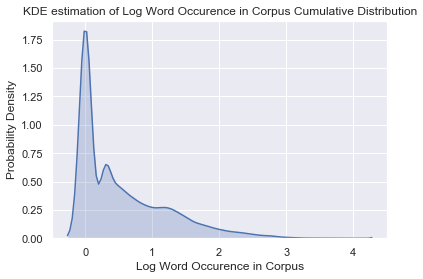

In [10]:
eda_word_occurence = np.count_nonzero(eda_text_matrix.toarray(), axis=0)
eda_word_percentiles = np.percentile(eda_word_occurence, [0, 50, 75, 95, 99, 99.9, 100])
sns.kdeplot(np.log10(eda_word_occurence), shade=True)
plt.title('KDE estimation of Log Word Occurence in Corpus Cumulative Distribution')
plt.xlabel('Log Word Occurence in Corpus')
plt.ylabel('Probability Density')
print('Minimum word occurence: ' + str(eda_word_percentiles[0]))
print('Median word occurence: ' + str(eda_word_percentiles[1]))
print('75th percentile word occurence: ' + str(eda_word_percentiles[2]))
print('95th percentile word occurence: ' + str(eda_word_percentiles[3]))
print('99th percentile word occurence: ' + str(eda_word_percentiles[4]))
print('99.9th percentile word occurence: ' + str(eda_word_percentiles[5]))
print('Maximum word occurence: ' + str(eda_word_percentiles[6]))

In [11]:
# Statistical Inference

single_topic_df = data_df[data_df.topic_count == 1].reset_index(drop=True).drop(columns='topic_count')
st_binary_df = single_topic_df.drop(columns=['title', 'text'])
st_drop_columns = st_binary_df.columns[st_binary_df.sum(axis='index') <= 10].values
single_topic_df.drop(columns=st_drop_columns, inplace=True)
single_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8678 entries, 0 to 8677
Data columns (total 45 columns):
title             8678 non-null object
text              8678 non-null object
interest          8678 non-null int64
reserves          8678 non-null int64
wpi               8678 non-null int64
trade             8678 non-null int64
livestock         8678 non-null int64
silver            8678 non-null int64
heat              8678 non-null int64
ship              8678 non-null int64
cotton            8678 non-null int64
tin               8678 non-null int64
strategicmetal    8678 non-null int64
housing           8678 non-null int64
moneysupply       8678 non-null int64
gold              8678 non-null int64
ipi               8678 non-null int64
gas               8678 non-null int64
mealfeed          8678 non-null int64
natgas            8678 non-null int64
lumber            8678 non-null int64
grain             8678 non-null int64
petchem           8678 non-null int64
moneyfx          

In [12]:
def centroid(matrix):
    m, n = matrix.shape
    cent = np.zeros(n)
    for i in range(n):
        cent[i] = matrix[:,i].mean()
    return cent
def square_distance(vector_1, vector_2):
    sq_dist = 0
    for i in range(len(vector_1)):
        sq_dist += (vector_2[i] - vector_1[i]) ** 2
    return sq_dist
def closest_distance(matrix):
    m, n = matrix.shape
    pairwise_distance = np.zeros((m,m))
    for i in range(m):
        for j in range(i+1,m):
            pairwise_distance[i,j] = square_distance(matrix[i], matrix[j])
    return np.unravel_index(np.argmax(pairwise_distance), pairwise_distance.shape)
def closest_centroids_inf(inf_data_df, inf_vectorizer):
    inf_vectorizer.fit(inf_data_df.text)
    topics = inf_data_df.drop(columns=['title','text']).columns.values
    inf_dict = {'topic':[], 'topic_matrix':[], 'topic_centroid':[]}
    for topic in topics:
        inf_dict['topic'].append(topic)
        mask = inf_data_df[topic].astype('bool')
        topic_matrix = inf_vectorizer.transform(inf_data_df[mask].text).toarray()
        inf_dict['topic_centroid'].append(centroid(topic_matrix))
        inf_dict['topic_matrix'].append(topic_matrix)
    inf_df = pd.DataFrame(inf_dict)
    centroids = np.concatenate(inf_df.topic_centroid.values).reshape((len(inf_df.index),\
        len(inf_df.loc[0,'topic_centroid'])))
    index_1, index_2 = closest_distance(centroids)
    topic_1 = inf_df.loc[index_1, 'topic']
    topic_2 = inf_df.loc[index_2, 'topic']
    topic_1_matrix = inf_df.loc[index_1, 'topic_matrix']
    topic_2_matrix = inf_df.loc[index_2, 'topic_matrix']
    topic_1_centroid = inf_df.loc[index_1, 'topic_centroid']
    topic_2_centroid = inf_df.loc[index_2, 'topic_centroid']
    topic_distance = np.sqrt(square_distance(topic_1_centroid, topic_2_centroid))
    topic_1_doc_count, _ = topic_1_matrix.shape
    topic_2_doc_count, _ = topic_2_matrix.shape
    topic_1_variance = 0
    topic_2_variance = 0
    for doc in range(topic_1_doc_count):
        topic_1_variance += square_distance(topic_1_matrix[doc], topic_1_centroid)
    for doc in range(topic_2_doc_count):
        topic_2_variance += square_distance(topic_2_matrix[doc], topic_2_centroid)
    topic_1_variance *= 1 / (topic_1_doc_count - 1)
    topic_2_variance *= 1 / (topic_2_doc_count - 1)
    degrees_of_freedom = topic_1_doc_count + topic_2_doc_count - 2
    standard_error = np.sqrt(((topic_1_doc_count - 1) * topic_1_variance + (topic_2_doc_count - 1) \
        * topic_2_variance) / degrees_of_freedom * (1 / topic_1_doc_count + 1 / topic_2_doc_count))
    t_stat = topic_distance / standard_error
    p_val = 1 - t.cdf(t_stat, degrees_of_freedom)
    return topic_1, topic_2, t_stat, p_val

In [13]:
inf_count_vectorizer = CountVectorizer(strip_accents='unicode', stop_words='english')
topic_1_count, topic_2_count, t_stat_count, p_val_count = closest_centroids_inf(single_topic_df, inf_count_vectorizer)
print('The closest 2 topics in our count vector space were: ', topic_1_count, topic_2_count)
print('The t statistic for the difference of topic centroids in the count space was: ', t_stat_count, '\n', \
   ' with associated p value: ', p_val_count)

The closest 2 topics in our count vector space were:  silver retail
The t statistic for the difference of topic centroids in the count space was:  2.311057033882131 
  with associated p value:  0.014350865776019961


In [14]:
inf_bin_vectorizer = CountVectorizer(strip_accents='unicode', stop_words='english', binary=True)
topic_1_bin, topic_2_bin, t_stat_bin, p_val_bin = closest_centroids_inf(single_topic_df, inf_bin_vectorizer)
print('The closest 2 topics in our binary vector space were: ', topic_1_bin, topic_2_bin)
print('The t statistic for the difference of topic centroids in the binary space was: ', t_stat_bin, '\n', \
   ' with associated p value: ', p_val_bin)

The closest 2 topics in our binary vector space were:  silver heat
The t statistic for the difference of topic centroids in the binary space was:  2.0442736878309193 
  with associated p value:  0.026269601168387058


In [15]:
inf_tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english')
topic_1_tfidf, topic_2_tfidf, t_stat_tfidf, p_val_tfidf = closest_centroids_inf(single_topic_df, inf_tfidf_vectorizer)
print('The closest 2 topics in our tfidf vector space were: ', topic_1_tfidf, topic_2_tfidf)
print('The t statistic for the difference of topic centroids in the tfidf space was: ', t_stat_tfidf, '\n', \
   ' with associated p value: ', p_val_tfidf)

The closest 2 topics in our tfidf vector space were:  heat housing
The t statistic for the difference of topic centroids in the tfidf space was:  3.1558042215089026 
  with associated p value:  0.0019541700688086028


In [17]:
# Multilabel Classification

train_df, test_df = train_test_split(data_df)
clf_text_vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english')
clf_text_vectorizer.fit(data_df.text)
x_train = clf_text_vectorizer.transform(train_df.text)
y_train = train_df.drop(columns=['title', 'text', 'topic_count'])
x_test = clf_text_vectorizer.transform(test_df.text)
y_test = test_df.drop(columns=['title', 'text', 'topic_count'])
classifier = BinaryRelevance(GaussianNB())
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_train_pred = classifier.predict(x_train)
print('Train Accuracy: ', accuracy_score(y_train, y_train_pred))
print('Train Hamming loss: ', hamming_loss(y_train, y_train_pred))
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('Test Hamming loss: ', hamming_loss(y_test, y_pred))


Train Accuracy:  0.9345529502705489
Train Hamming loss:  0.0018836913322870551
Test Accuracy:  0.4868624420401855
Test Hamming loss:  0.012792140883330992
